In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest

In [41]:
ab_data = pd.read_csv('ab_data.csv')
ab_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [3]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


## Vorverarbeitung von Daten

In [7]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [12]:
ab_data.apply(lambda x: x.nunique())

user_id         290585
timestamp        35993
group                2
landing_page         2
converted            2
dtype: int64

In [73]:
# Datentypen konvertieren
ab_data['group'] = ab_data['group'].astype('category')
ab_data['landing_page'] = ab_data['landing_page'].astype('category')

In [43]:
# Überprüfung auf fehlende Werte
ab_data.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [74]:
# Duplikate entfernen
ab_data.drop_duplicates(subset=['user_id'], keep=False, inplace=True)

In [34]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290586 entries, 0 to 290585
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290586 non-null  int64 
 1   country  290586 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [36]:
countries.apply(lambda x: x.nunique())

user_id    290585
country         3
dtype: int64

In [75]:
# Duplikate entfernen
countries.drop_duplicates(subset=['user_id'], keep=False, inplace=True)

## Группировка данных по group и подсчёт конверсий

In [76]:
# Datentypen konvertieren
countries['country'] = countries['country'].astype('category')

In [77]:
# Überprüfung der Verteilung von Gruppen und Seiten
inconsistencies = ab_data[
    ((ab_data['group'] == 'treatment') & (ab_data['landing_page'] != 'new_page')) |
    ((ab_data['group'] == 'control') & (ab_data['landing_page'] != 'old_page'))
]

print("Число несоответствий:", len(inconsistencies))

Число несоответствий: 0


In [78]:
# Gruppierung der Daten nach "group" und Zählen der Konversionen
conversion_summary = ab_data.groupby('group')['converted'].agg(['sum', 'count', 'mean'])

# Spalten zur besseren Lesbarkeit umbenennen
conversion_summary.columns = ['anzahl_konvertiert', 'gesamtbenutzer', 'konversionsrate']

conversion_summary

,anzahl_konvertiert,gesamtbenutzer,konversionsrate
group,,,
control,17220,143293,0.120173
treatment,17025,143397,0.118726


## Visualisierung der Verteilung der Zielvariablen für jede Gruppe


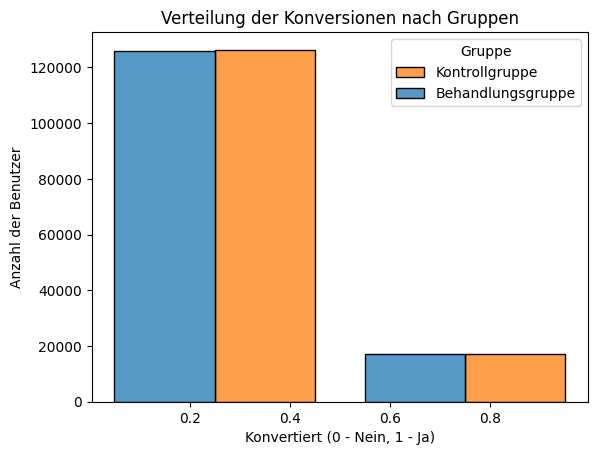

In [79]:
sns.histplot(data=ab_data, x='converted', hue='group', multiple='dodge', shrink=0.8, bins=2)

plt.title('Verteilung der Konversionen nach Gruppen')
plt.xlabel('Konvertiert (0 - Nein, 1 - Ja)')
plt.ylabel('Anzahl der Benutzer')
plt.legend(title='Gruppe', labels=['Kontrollgruppe', 'Behandlungsgruppe'])
plt.show()

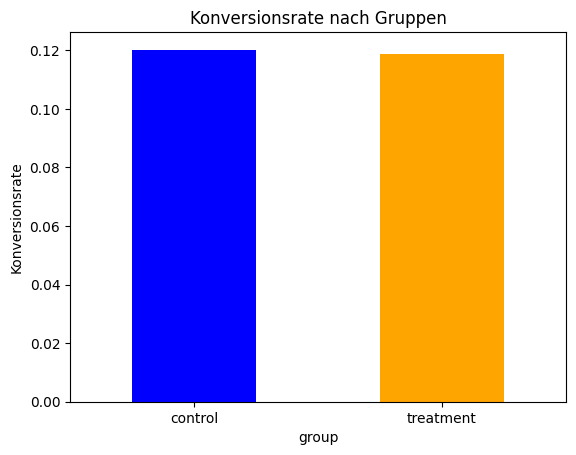

In [80]:
conversion_rates = ab_data.groupby('group')['converted'].mean()

conversion_rates.plot(kind='bar', color=['blue', 'orange'])

plt.title('Konversionsrate nach Gruppen')
plt.ylabel('Konversionsrate')
plt.xticks(rotation=0)
plt.show()

Auf den Visualisierungen ist kein Unterschied zwischen den Gruppen erkennbar. Dennoch überprüfen wir dies mit einem Z-Test.


## Z-тест для пропорций

In [81]:
# Anzahl der Konversionen und Gesamtzahl der Benutzer berechnen
conversions_new = ab_data[ab_data['group'] == 'treatment']['converted'].sum()
conversions_old = ab_data[ab_data['group'] == 'control']['converted'].sum()

n_new = len(ab_data[ab_data['group'] == 'treatment'])
n_old = len(ab_data[ab_data['group'] == 'control'])

# Konversionsraten
P_new = conversions_new / n_new
P_old = conversions_old / n_old

# Gesamte Konversionsrate (P_pool)
P_pool = (conversions_new + conversions_old) / (n_new + n_old)

# Standardfehler (SE)
SE = np.sqrt(P_pool * (1 - P_pool) * (1/n_new + 1/n_old))

# Z-Statistik
Z = (P_new - P_old) / SE

# p-Wert für den zweiseitigen Test
p_value = 2 * (1 - norm.cdf(abs(Z)))

# Ausgabe der Ergebnisse
print(f'Z-Statistik: {Z}')
print(f'p-Wert: {p_value}')

Z-Statistik: -1.1944850812796501
p-Wert: 0.23228827305833621


p-value (0.2323) ist größer als das übliche Signifikanzniveau von 𝛼=0.05. Das bedeutet, dass es keine ausreichenden Beweise gibt, um die H0 abzulehnen. Die H0 besagt, dass es keinen Unterschied in den Konversionsraten zwischen der Kontrollgruppe (alte Seite) und der Testgruppe (neue Seite) gibt.


## Überprüfung des Einflusses externer Faktoren (Länder)


In [82]:
# Kombinieren der Länderdaten mit dem Hauptdatensatz
df_countries = ab_data.merge(countries, on='user_id', how='left')
df_countries.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


In [83]:
# Verteilung der Konversionen nach Ländern und Gruppen
country_conversion = df_countries.groupby(['country', 'group'])['converted'].mean().reset_index()
country_conversion.head()

,country,group,converted
0,CA,control,0.118974
1,CA,treatment,0.112360
2,UK,control,0.119695
3,UK,treatment,0.121162
4,US,control,0.120429


Visualisierung nach Ländern

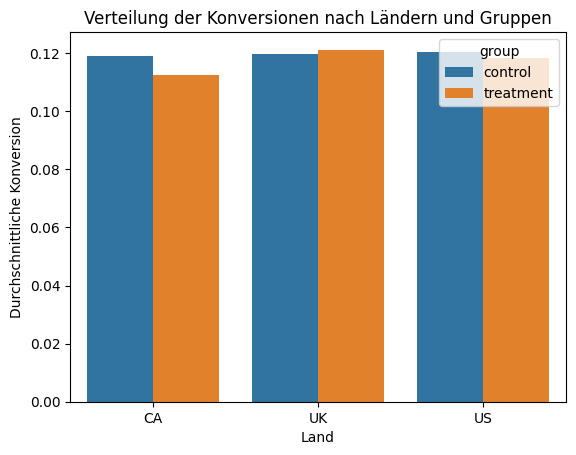

In [84]:
sns.barplot(data=country_conversion, x='country', y='converted', hue='group')
plt.title('Verteilung der Konversionen nach Ländern und Gruppen')
plt.ylabel('Durchschnittliche Konversion')
plt.xlabel('Land')
plt.show()

In [86]:
# Funktion zur Durchführung des Z-Tests für jedes Land
results_by_country = []

for country in df_countries['country'].unique():
    country_data = df_countries[df_countries['country'] == country]
    
    conversions = country_data.groupby('group')['converted'].sum()
    n_users = country_data.groupby('group')['converted'].count()
    
    # Überprüfen, ob genügend Daten für die Analyse vorhanden sind
    if n_users.min() > 10:  
        z_stat, p_value = proportions_ztest(conversions, n_users)
        results_by_country.append((country, z_stat, p_value))
for country, z_stat, p_value in results_by_country:
    print(f'Land: {country}, Z-Statistik: {z_stat:.2f}, p-value: {p_value:.4f}')

Land: US, Z-Statistik: 1.46, p-value: 0.1448
Land: CA, Z-Statistik: 1.24, p-value: 0.2162
Land: UK, Z-Statistik: -0.60, p-value: 0.5466


In allen drei Ländern ist der p-value größer als das übliche Signifikanzniveau von 0.05. Das bedeutet, dass der Unterschied in der Konversion zwischen der Treatment-Gruppe (neue Seite) und der Control-Gruppe (alte Seite) für jedes Land statistisch nicht signifikant ist. Da in keinem der Länder die neue Seite eine statistisch signifikante Verbesserung gezeigt hat, ist es besser, die alte Seite beizubehalten.